In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pandas as pd
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

# Model functions
## Global constants

In [3]:
AMBIENT = 25
HOT = 50
COLD = 0

## Functions initizalizing the grid

In [4]:
def apply_hot_cold(bar, hot_sites, cold_sites):
    for i in range(hot_sites.shape[0]):
        bar[int(hot_sites[i][0]), int(hot_sites[i][1])] = HOT
    for i in range(cold_sites.shape[0]):
        bar[int(cold_sites[i][0]), int(cold_sites[i][1])] = COLD
    return bar

def init_bar(m, n, hot_sites, cold_sites):
    ambient_bar = AMBIENT * np.ones((m,n))
    return apply_hot_cold(ambient_bar, hot_sites, cold_sites)

## Moore Neighbourhood

In [5]:
def diffusion(diffusion_rate, site, N, NE, E, SE, S, SW, W, NW):
    return (1 - 8*diffusion_rate)*site + diffusion_rate*(N + NE + E + SE + S + SW + W + NW)

## Von Neumann Neighbourhood

In [6]:
def von_diffusion(diffusion_rate, site, N, E, S, W):
    return (1 - 4*diffusion_rate)*site + diffusion_rate*(N + E + S + W)

## Weighted sum diffusion

In [7]:
def weighted_diffusion(diffusion_rate, site, N, NE, E, SE, S, SW, W, NW):
    return 0.25*site + 0.125*(N + E + S + W) + 0.0625*(NE + SE+ SW + NW)

## Stochastic diffusion

In [8]:
def random_diffusion(diffusion_rate, site, N, NE, E, SE, S, SW, W, NW):
    sum1 = 0
    val = 0
    
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * N
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * NE
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * E
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * SE
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * S
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * SW
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * W
    x = diffusion_rate * (1 + np.random.normal(0,0.5))
    sum1 += x
    val += x * NW
    
    return (1 - sum1)*site + val

## Reflective Boundary

In [9]:
def reflecting_lat(lat):
    lat_NS = np.row_stack((lat[0], lat, lat[-1]))
    return np.column_stack((lat_NS[:,0], lat_NS, lat_NS[:,-1]))

## Absorbing Boundary

In [10]:
def absorbing_lat(lat, k):
    kk = k*np.ones_like(lat[0])
    lat_NS = np.row_stack((kk, lat, kk))
    ww = k*np.ones_like(lat_NS[:,0])
    return np.column_stack((ww, lat_NS, ww))

## Periodic Boundary

In [11]:
def periodic_lat(lat):
    lat_NS = np.row_stack((lat[-1], lat, lat[0]))
    return np.column_stack((lat_NS[:,-1], lat_NS, lat_NS[:,0]))    

## Simulation functions

In [12]:
def apply_diffusion_extended(diffusion_rate, bar_ext):
    m = bar_ext.shape[0] - 2
    n = bar_ext.shape[1] - 2
    new_bar = np.zeros((m, n))
    for i in range(1, m+1):
        for j in range(1, n+1):
            site = bar_ext[i][j]
            N = bar_ext[i-1][j]
            NE = bar_ext[i-1][j+1]
            E = bar_ext[i][j+1]
            SE = bar_ext[i+1][j+1]
            S = bar_ext[i+1][j]
            SW = bar_ext[i+1][j-1]
            W = bar_ext[i][j-1]
            NW = bar_ext[i-1][j-1]
            new_bar[i-1][j-1] = diffusion(diffusion_rate, site, N, NE, E, SE, S, SW, W, NW)
    return new_bar

In [13]:
def apply_von_diffusion_extended(diffusion_rate, bar_ext):
    m = bar_ext.shape[0] - 2
    n = bar_ext.shape[1] - 2
    new_bar = np.zeros((m, n))
    for i in range(1, m+1):
        for j in range(1, n+1):
            site = bar_ext[i][j]
            N = bar_ext[i-1][j]
            E = bar_ext[i][j+1]
            S = bar_ext[i+1][j]
            W = bar_ext[i][j-1]
            new_bar[i-1][j-1] = von_diffusion(diffusion_rate, site, N, E, S, W)
    return new_bar

In [14]:
def apply_weighted_diffusion_extended(diffusion_rate, bar_ext):
    m = bar_ext.shape[0] - 2
    n = bar_ext.shape[1] - 2
    new_bar = np.zeros((m, n))
    for i in range(1, m+1):
        for j in range(1, n+1):
            site = bar_ext[i][j]
            N = bar_ext[i-1][j]
            NE = bar_ext[i-1][j+1]
            E = bar_ext[i][j+1]
            SE = bar_ext[i+1][j+1]
            S = bar_ext[i+1][j]
            SW = bar_ext[i+1][j-1]
            W = bar_ext[i][j-1]
            NW = bar_ext[i-1][j-1]
            new_bar[i-1][j-1] = weighted_diffusion(diffusion_rate, site, N, NE, E, SE, S, SW, W, NW)
    return new_bar

In [15]:
def apply_random_diffusion_extended(diffusion_rate, bar_ext):
    m = bar_ext.shape[0] - 2
    n = bar_ext.shape[1] - 2
    new_bar = np.zeros((m, n))
    for i in range(1, m+1):
        for j in range(1, n+1):
            site = bar_ext[i][j]
            N = bar_ext[i-1][j]
            NE = bar_ext[i-1][j+1]
            E = bar_ext[i][j+1]
            SE = bar_ext[i+1][j+1]
            S = bar_ext[i+1][j]
            SW = bar_ext[i+1][j-1]
            W = bar_ext[i][j-1]
            NW = bar_ext[i-1][j-1]
            new_bar[i-1][j-1] = random_diffusion(diffusion_rate, site, N, NE, E, SE, S, SW, W, NW)
    return new_bar

In [16]:
def diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, neighbourhood):
    bar = init_bar(m, n, hot_sites, cold_sites)
    grids = np.zeros((t+1, m, n))
    grids[0,:,:] = bar
    if(neighbourhood == True):
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = reflecting_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    else:
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = reflecting_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    return grids

In [17]:
def periodic_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, neighbourhood):
    bar = init_bar(m, n, hot_sites, cold_sites)
    grids = np.zeros((t+1, m, n))
    grids[0,:,:] = bar
    if(neighbourhood == True):
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = periodic_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    else:
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = periodic_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    return grids

In [18]:
def absorbing_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, neighbourhood, k):
    bar = init_bar(m, n, hot_sites, cold_sites)
    grids = np.zeros((t+1, m, n))
    grids[0,:,:] = bar
    if(neighbourhood == True):
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = absorbing_lat(bar, k)
            # do the rule based diffusion to all the points
            bar = apply_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    else:
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = absorbing_lat(bar, k)
            # do the rule based diffusion to all the points
            bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    return grids

In [19]:
def weighted_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, neighbourhood):
    bar = init_bar(m, n, hot_sites, cold_sites)
    grids = np.zeros((t+1, m, n))
    grids[0,:,:] = bar
    if(neighbourhood == True):
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = reflecting_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_weighted_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    else:
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = reflecting_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    return grids

# Example simulation
The following driver code simulates the example given in the module using the functions defined in this notebook.
<br>
Size of the grid = m * n = 10 * 30
<br>
diffusion rate (r) = 0.1
<br>
Boundary condition applied : Reflective boundary - the assumption being the air temperature around the rod is same as the surface of the rod 
<br>
Neighbourhood considered: Moore neighbourhood
<br>
Simulation time (t) = 100 sec

In [100]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
t = 100

# calling the function to simulate as per the above imput conditions
# neighbourhood = True for Moore, False for Von Neumann
grids = diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True)

Text(0.5, 1, 'Metal bar at t = 0')

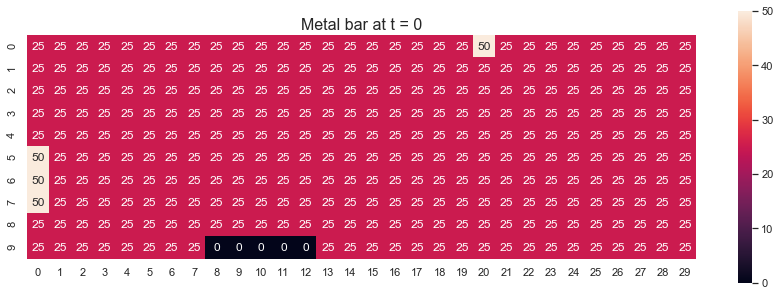

In [101]:
sns.set(rc={'figure.figsize':(15,5)})
ax = plt.axes()
sns.heatmap(grids[0,:,:], annot=True, square=True, ax = ax)
ax.set_title('Metal bar at t = 0', fontsize=16)

Text(0.5, 1, 'Metal bar at t = 1')

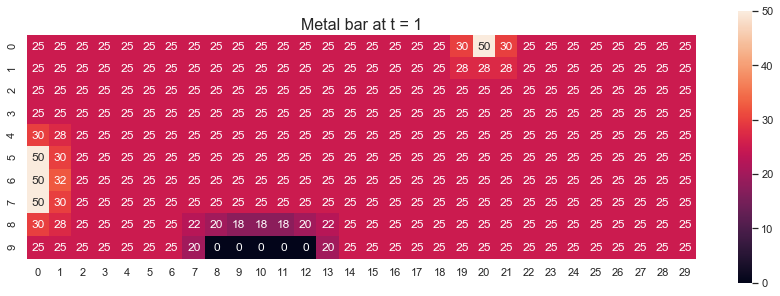

In [102]:
sns.set(rc={'figure.figsize':(15,5)})
ax = plt.axes()
sns.heatmap(grids[1,:,:], annot=True, square=True, ax = ax)
ax.set_title('Metal bar at t = 1', fontsize=16)

Text(0.5, 1, 'Metal bar at t = 25')

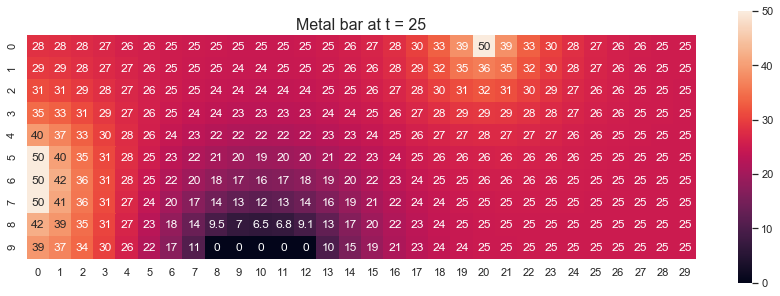

In [103]:
sns.set(rc={'figure.figsize':(15,5)})
ax = plt.axes()
sns.heatmap(grids[25,:,:], annot=True, square=True, ax = ax)
ax.set_title('Metal bar at t = 25', fontsize=16)

## Generating the video for the simulation of cell temperature

In [104]:
def generate_animation(grids, filename):
    t = grids.shape[0]
    fig = plt.figure()

    def init():
        plt.clf()
        sns.set(rc={'figure.figsize':(15,5)})
        ax = plt.axes()
        sns.heatmap(grids[0,:,:], annot=True, square=True)
        ax.set_title('Metal bar at t = 0', fontsize=16)

    def animate(i):
        plt.clf()
        sns.set(rc={'figure.figsize':(15,5)})
        ax = plt.axes()
        sns.heatmap(grids[i,:,:], annot=True, square=True)
        ax.set_title('Metal bar at t = '+str(i), fontsize=16)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=t, repeat = False)

    anim.save(filename, writer = 'ffmpeg', fps = 10)

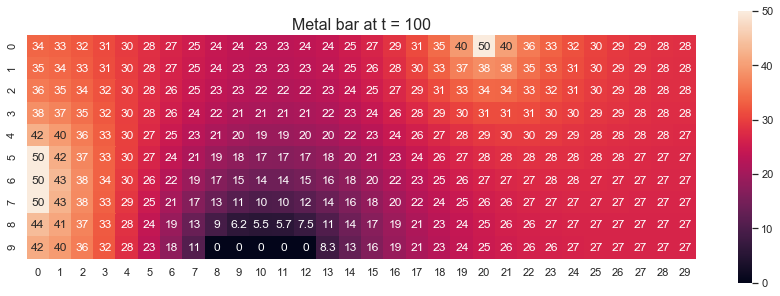

In [105]:
generate_animation(grids, 'anim-1.mp4')

# Module 10.2 Project 1
a. Determine how long it takes, t, for the bar modeled in this module to reach
equilibrium, where from time t to time t + 1 the values in each cell vary by
no more than plus or minus some small value, such as ±0.001.
<br>
b. Repeat Part a, applying heat and cold for 10 time steps and then removing
such heating and cooling.
<br>
<br>
Function equilibrium_sim handles the case for 1a, equilibrium_apply_sim handles the case for 1b.

In [62]:
def equilibrium_sim(m, n, diffusion_rate, hot_sites, cold_sites, threshold):
    bar = init_bar(m, n, hot_sites, cold_sites)
    t = 0
    grid = bar
    flag = False
    while(not flag):
        # apply the boundary condition and extend the cells
        bar_ext = reflecting_lat(bar)
        # do the rule based diffusion to all the points
        bar = apply_diffusion_extended(diffusion_rate, bar_ext)
        bar = apply_hot_cold(bar, hot_sites, cold_sites)
        t =  t + 1
        diff = np.absolute(np.subtract(bar, grid))
        #print(diff)
        diff1 = diff.flatten()
        #print(diff1)
        flag = all(i <= threshold for i in diff1)
        #print(flag)
        grid = bar
    print("Time taken to achieve the equilibrium: ", t)
    sns.set(rc={'figure.figsize':(15,5)})
    ax = plt.axes()
    sns.heatmap(grid, annot=True, square=True, ax = ax)
    ax.set_title('Metal bar at equilibrium t = '+str(t), fontsize=16)

Time taken to achieve the equilibrium:  1005


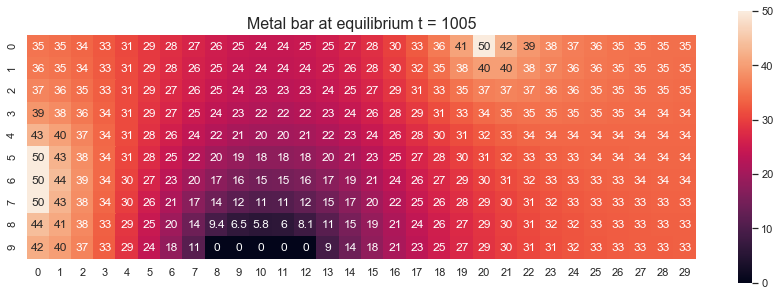

In [63]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
thresh = 0.001

# calling the function to simulate as per the above imput conditions
equilibrium_sim(m, n, diffusion_rate, hot_sites, cold_sites, thresh)

In [79]:
def equilibrium_apply_sim(m, n, diffusion_rate, hot_sites, cold_sites, threshold, apply_time):
    bar = init_bar(m, n, hot_sites, cold_sites)
    t = 0
    grid = bar
    flag = False
    while(not flag):
        # apply the boundary condition and extend the cells
        bar_ext = reflecting_lat(bar)
        # do the rule based diffusion to all the points
        bar = apply_diffusion_extended(diffusion_rate, bar_ext)
        t =  t + 1
        if (t <= apply_time):
            #print("applied")
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
        diff = np.absolute(np.subtract(bar, grid))
        diff1 = diff.flatten()
        #print(diff1)
        flag = all(i <= threshold for i in diff1)
        #print(flag)
        grid = bar
    print("Time taken to achieve the equilibrium: ", t)
    sns.set(rc={'figure.figsize':(15,5)})
    ax = plt.axes()
    sns.heatmap(grid, annot=True, square=True, ax = ax)
    ax.set_title('Metal bar at equilibrium t = '+str(t), fontsize=16)

Time taken to achieve the equilibrium:  297


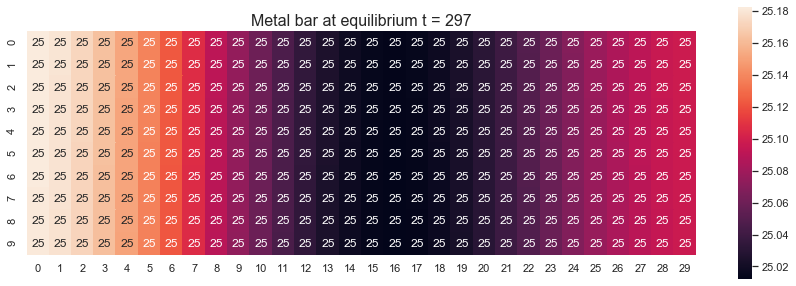

In [80]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
thresh = 0.001
apply_time = 10

# calling the function to simulate as per the above imput conditions
equilibrium_apply_sim(m, n, diffusion_rate, hot_sites, cold_sites, thresh, apply_time)

# Module 10.2 Project 2
Develop simulations and animations for the bar modeled in this module using
several boundary conditions: three simulations of absorbing boundary conditions
with constant values 0, 25, and 50 and periodic boundary conditions.
Along with the reflecting boundary conditions, describe the results. Discuss
the advantages and disadvantages of each approach and the situations, such
as heat or pollution diffusion, for which each is most appropriate.

### Absorbing boundary for constants 0, 25 and 50

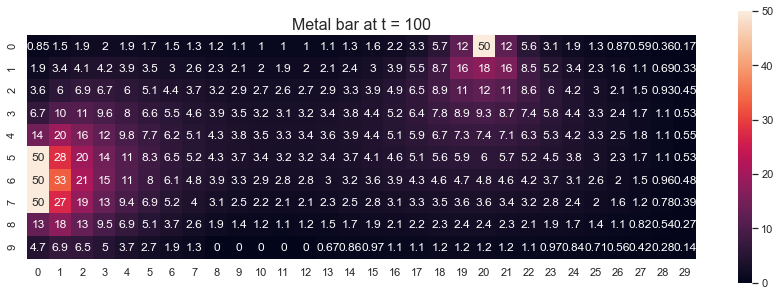

In [106]:
grids = absorbing_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True, 0)
generate_animation(grids, 'anim-2.mp4')

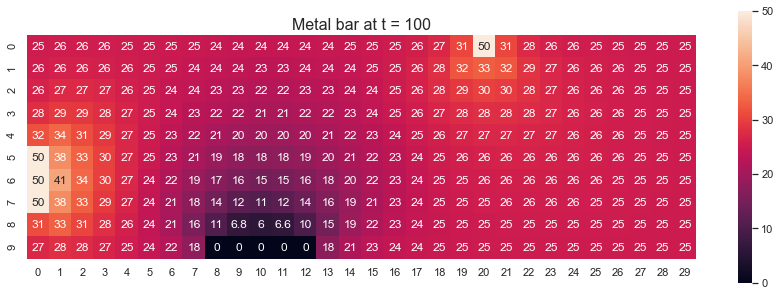

In [107]:
grids = absorbing_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True, 25)
generate_animation(grids, 'anim-3.mp4')

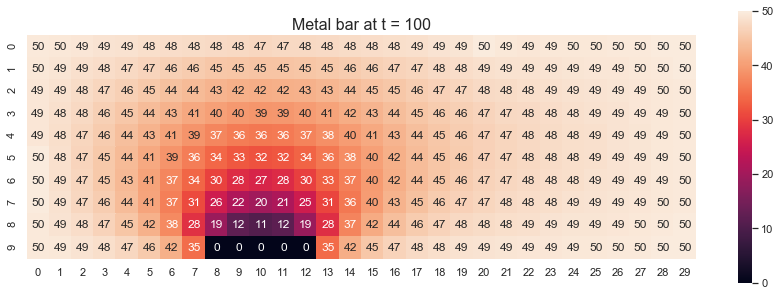

In [108]:
grids = absorbing_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True, 50)
generate_animation(grids, 'anim-4.mp4')

### Periodic boundary

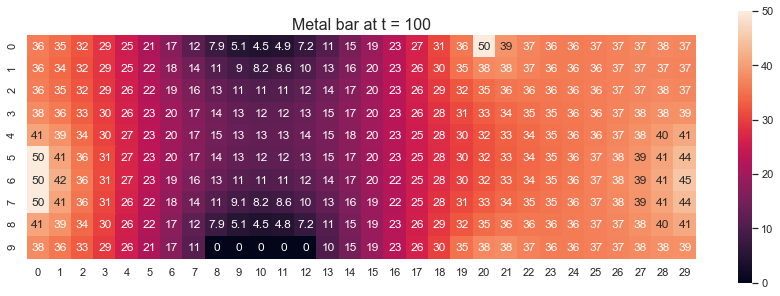

In [109]:
grids = periodic_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True)
generate_animation(grids, 'anim-5.mp4')

# Module 10.2 Project 3
Instead of using the formula for diffusion in the section “Heat Diffusion,”
employ the filter in Figure 10.2.13. Thus, to obtain the value at a site for time
t + 1, we add 25% of the site’s temperature at time t, 12.5% of the north, east,
south, and west cells at time t, and 6.25% of the corner cells to the northeast,
southeast, southwest, and northwest. This sum is called a weighted sum with
each nutrition value carrying a particular weight as indicated by the table.
Revise the model using this configuration and compare the results with that
of the module.

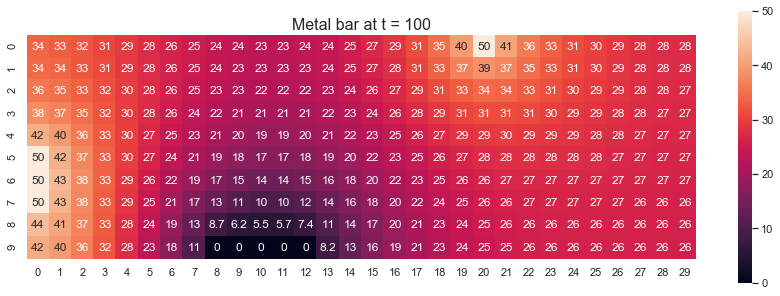

In [168]:
grids = weighted_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True)
generate_animation(grids, 'anim-6.mp4')

In [1]:
def weighted_equilibrium_sim(m, n, diffusion_rate, hot_sites, cold_sites, threshold):
    bar = init_bar(m, n, hot_sites, cold_sites)
    t = 0
    grid = bar
    flag = False
    while(not flag):
        # apply the boundary condition and extend the cells
        bar_ext = reflecting_lat(bar)
        # do the rule based diffusion to all the points
        bar = apply_weighted_diffusion_extended(diffusion_rate, bar_ext)
        bar = apply_hot_cold(bar, hot_sites, cold_sites)
        t =  t + 1
        diff = np.absolute(np.subtract(bar, grid))
        #print(diff)
        diff1 = diff.flatten()
        #print(diff1)
        flag = all(i <= threshold for i in diff1)
        #print(flag)
        grid = bar
    print("Time taken to achieve the equilibrium: ", t)
    sns.set(rc={'figure.figsize':(15,5)})
    ax = plt.axes()
    sns.heatmap(grid, annot=True, square=True, ax = ax)
    ax.set_title('Metal bar at equilibrium t = '+str(t), fontsize=16)

Time taken to achieve the equilibrium:  1143


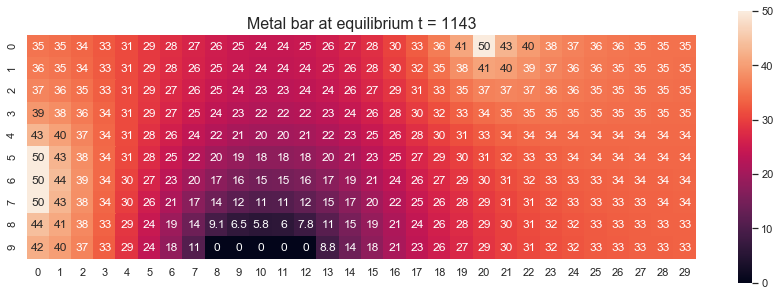

In [20]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
thresh = 0.001

# calling the function to simulate as per the above imput conditions
weighted_equilibrium_sim(m, n, diffusion_rate, hot_sites, cold_sites, thresh)

# Module 10.2 Project 4
a. Model a bar at 100 °C that has a constant application of a 25 °C external
source on its boundary. Generate plots of the temperatures at a corner and in the middle of the bar versus time. Describe the shapes of the graphs.
<br>
b. Repeat Part a with the bar being at –50 °C.
<br>
c. Discuss the results.

In [126]:
def absorbing_diffusion_sim_noconst(m, n, diffusion_rate, hot_sites, cold_sites, t, neighbourhood, k):
    bar = init_bar(m, n, hot_sites, cold_sites)
    grids = np.zeros((t+1, m, n))
    grids[0,:,:] = bar
    if(neighbourhood == True):
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = absorbing_lat(bar, k)
            # do the rule based diffusion to all the points
            bar = apply_diffusion_extended(diffusion_rate, bar_ext)
            #bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    else:
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = absorbing_lat(bar, k)
            # do the rule based diffusion to all the points
            bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
            #bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    return grids

In [132]:
AMBIENT = 100
HOT = 100
COLD = 100
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[0,0]])
cold_sites = np.array([[0,0]])
t = 100

ext_temp = 25

# calling the function to simulate as per the above imput conditions
# neighbourhood = True for Moore, False for Von Neumann
grids = absorbing_diffusion_sim_noconst(m, n, diffusion_rate, hot_sites, cold_sites, t, True, ext_temp)

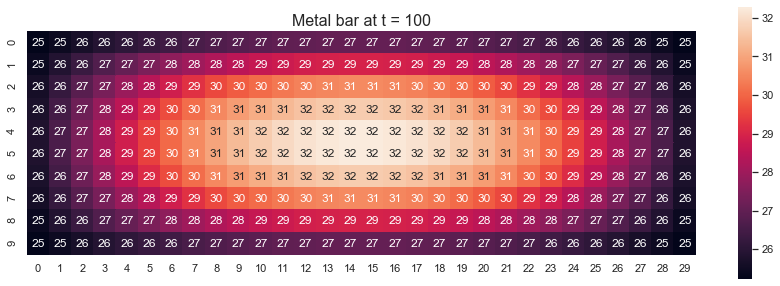

In [133]:
generate_animation(grids, 'anim-7.mp4')

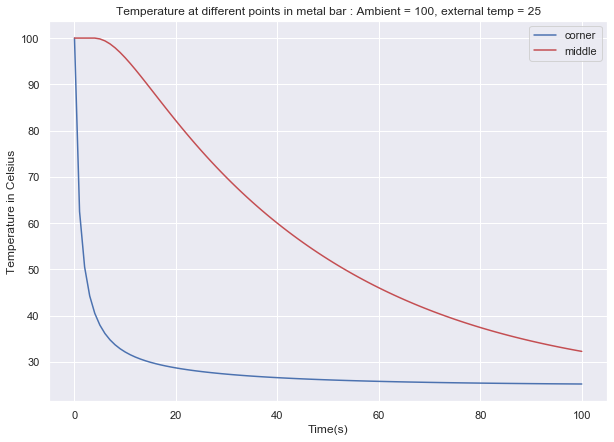

In [148]:
plt.figure(figsize=(10, 7))
time = np.arange(0, t+1, 1)
plt.plot(time, grids[:,0,0], label='corner')
plt.plot(time, grids[:,5,15], 'r', label='middle')
plt.title('Temperature at different points in metal bar : Ambient = 100, external temp = 25')
plt.xlabel('Time(s)')
plt.ylabel('Temperature in Celsius')
plt.legend()

In [149]:
AMBIENT = -50
HOT = -50
COLD = -50
m = 10
n = 30
diffusion_rate = 0.1
# for no sites as input give -1
hot_sites = np.array([[0,0]])
cold_sites = np.array([[0,0]])
t = 100

ext_temp = 25

# calling the function to simulate as per the above imput conditions
# neighbourhood = True for Moore, False for Von Neumann
grids = absorbing_diffusion_sim_noconst(m, n, diffusion_rate, hot_sites, cold_sites, t, True, ext_temp)

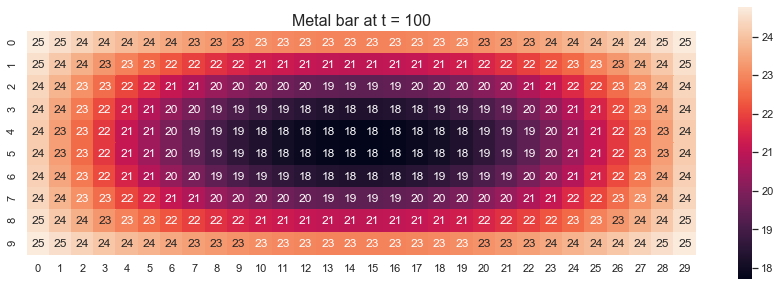

In [150]:
generate_animation(grids, 'anim-8.mp4')

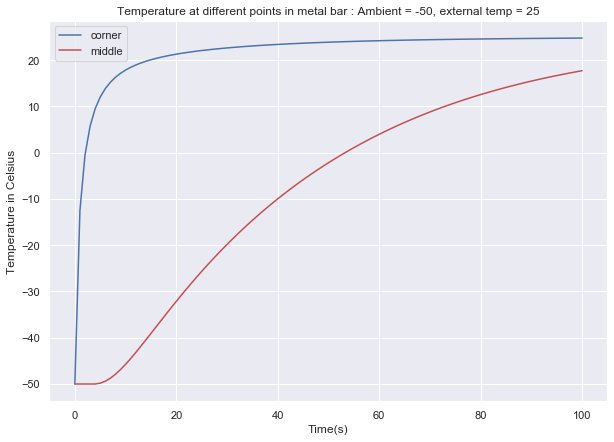

In [151]:
plt.figure(figsize=(10, 7))
time = np.arange(0, t+1, 1)
plt.plot(time, grids[:,0,0], label='corner')
plt.plot(time, grids[:,5,15], 'r', label='middle')
plt.title('Temperature at different points in metal bar : Ambient = -50, external temp = 25')
plt.xlabel('Time(s)')
plt.ylabel('Temperature in Celsius')
plt.legend()

## Module 10.2 Project 9
Often because of imperfections, variations in media, or other factors, diffusion
does not proceed deterministically but varies slightly with an element
of chance. Revise the function diffusion, which the section “Heat Diffusion”
describes, to be stochastic. Instead of multiplying each neighbori by r,
the rate of diffusion, multiply each neighboring temperature by a different
(1 + rndi)r, where rndi is a normally distributed random number with mean
0 and standard deviation 0.5. Adjust the coefficient of site so that the sum of
all the coefficients is 1. Run the model 100 times for 20 time steps and determine
the mean and range of temperatures for a designated cell towards
the middle of the bar.

In [161]:
def stochastic_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, neighbourhood):
    bar = init_bar(m, n, hot_sites, cold_sites)
    grids = np.zeros((t+1, m, n))
    grids[0,:,:] = bar
    if(neighbourhood == True):
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = reflecting_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_random_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    else:
        for i in range(1, t+1):
            # apply the boundary condition and extend the cells
            bar_ext = reflecting_lat(bar)
            # do the rule based diffusion to all the points
            bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
            bar = apply_hot_cold(bar, hot_sites, cold_sites)
            grids[i,:,:] = bar
    return grids

In [164]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
t = 100

# calling the function to simulate as per the above imput conditions
# neighbourhood = True for Moore, False for Von Neumann
grids = stochastic_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True)

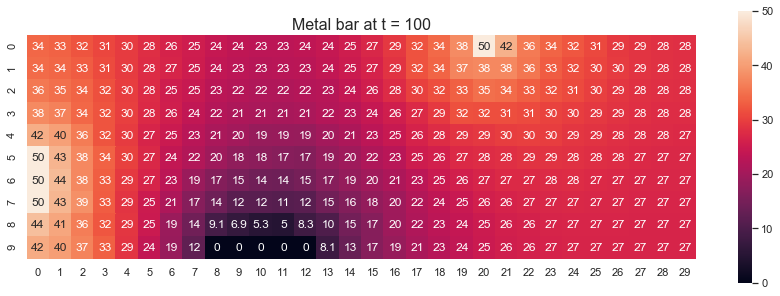

In [165]:
generate_animation(grids, 'anim-9.mp4')

In [170]:
exp = 20
t = 20
avg_temp = np.zeros((t+1))
for i in range(exp):
    grids = stochastic_diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, True)
    avg_temp = avg_temp + grids[:,5,15]
avg_temp = avg_temp/exp

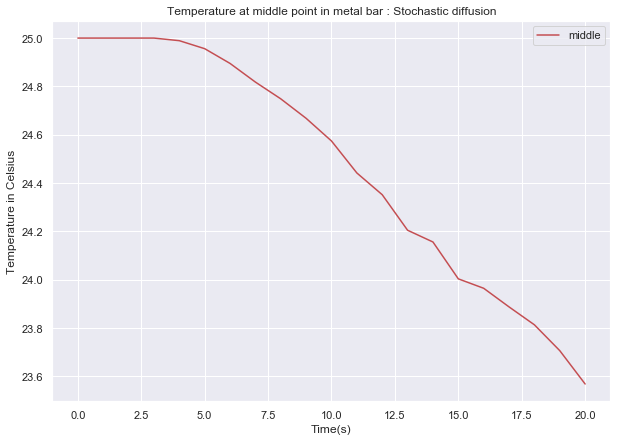

In [171]:
plt.figure(figsize=(10, 7))
time = np.arange(0, t+1, 1)
plt.plot(time, avg_temp, 'r', label='middle')
plt.title('Temperature at middle point in metal bar : Stochastic diffusion')
plt.xlabel('Time(s)')
plt.ylabel('Temperature in Celsius')
plt.legend()

# Von Neumann Neighbourhood simulation

diffusion rate (r) = 0.1
<br>
Boundary condition applied : Reflective boundary - the assumption being the air temperature around the rod is same as the surface of the rod 
<br>
Neighbourhood considered: Von Neumann neighbourhood
<br>
Simulation time (t) = 100 sec

In [172]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
t = 100

# calling the function to simulate as per the above imput conditions
# neighbourhood = True for Moore, False for Von Neumann
grids = diffusion_sim(m, n, diffusion_rate, hot_sites, cold_sites, t, False)

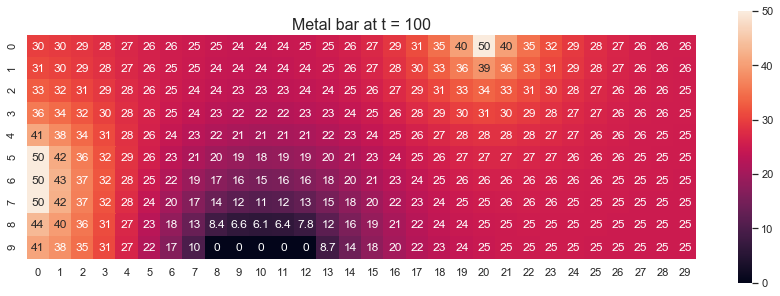

In [173]:
generate_animation(grids, 'anim-10.mp4')

In [21]:
def von_equilibrium_sim(m, n, diffusion_rate, hot_sites, cold_sites, threshold):
    bar = init_bar(m, n, hot_sites, cold_sites)
    t = 0
    grid = bar
    flag = False
    while(not flag):
        # apply the boundary condition and extend the cells
        bar_ext = reflecting_lat(bar)
        # do the rule based diffusion to all the points
        bar = apply_von_diffusion_extended(diffusion_rate, bar_ext)
        bar = apply_hot_cold(bar, hot_sites, cold_sites)
        t =  t + 1
        diff = np.absolute(np.subtract(bar, grid))
        #print(diff)
        diff1 = diff.flatten()
        #print(diff1)
        flag = all(i <= threshold for i in diff1)
        #print(flag)
        grid = bar
    print("Time taken to achieve the equilibrium: ", t)
    sns.set(rc={'figure.figsize':(15,5)})
    ax = plt.axes()
    sns.heatmap(grid, annot=True, square=True, ax = ax)
    ax.set_title('Metal bar at equilibrium t = '+str(t), fontsize=16)

Time taken to achieve the equilibrium:  2092


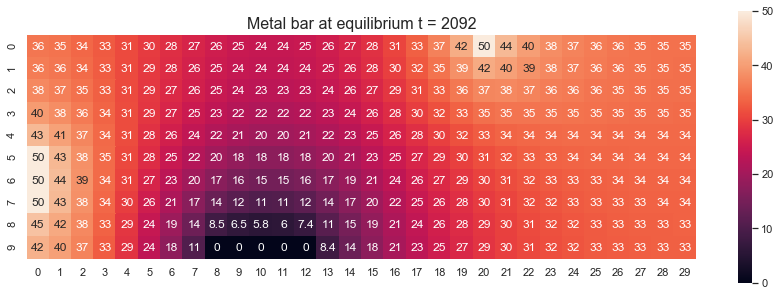

In [22]:
AMBIENT = 25
HOT = 50
COLD = 0
m = 10
n = 30
diffusion_rate = 0.1
hot_sites = np.array([[5,0],[6,0],[7,0],[0,20]])
cold_sites = np.array([[9,8],[9,9],[9,10],[9,11],[9,12]])
thresh = 0.001

# calling the function to simulate as per the above imput conditions
von_equilibrium_sim(m, n, diffusion_rate, hot_sites, cold_sites, thresh)